## DFBA of *S. cerevisiae* 

Based on this example: 
https://gitlab.com/davidtourigny/dynamic-fba/-/blob/main/examples/example3.py

from:
https://dynamic-fba.readthedocs.io/en/latest/examples.html

REMEMBER to run in the dfba env


CHECK THIS OUT: https://cobrapy.readthedocs.io/en/0.19.0/dfba.html



In [1]:
# Copyright (C) 2018, 2019 Columbia University Irving Medical Center,
#     New York, USA
# Copyright (C) 2019 Novo Nordisk Foundation Center for Biosustainability,
#     Technical University of Denmark

# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.

# You should have received a copy of the GNU General Public License
# along with this program. If not, see <http://www.gnu.org/licenses/>.

"""Aerobic growth of *S. cerevisiae* on glucose.

Switch to anaerobic conditions at *t=7.7h*
Organism -> Saccharomyces cerevisiae S288C
Model stored in http://bigg.ucsd.edu/models/iND750
"""

from os.path import dirname, join, pardir

from cobra.io import read_sbml_model

from dfba import ControlParameter, DfbaModel, ExchangeFlux, KineticVariable


In [2]:
from dfba.plot.matplotlib import *

In [3]:
from dfba import DfbaModel, ExchangeFlux, KineticVariable
from cobra import Model, Reaction, Metabolite

In [4]:
# DfbaModel instance initialized with cobra model
# fba_model = read_sbml_model(
#     join(dirname(__file__), pardir, "sbml-models", "iND750.xml.gz")
# )

fba_model = read_sbml_model('../../models/iMM904_progesterone.xml')

In [5]:
#fba_model.add_boundary(fba_model.metabolites.get_by_id('progesterone_e'), type='exchange')

fba_model.add_boundary(fba_model.metabolites.get_by_id('progesterone_c'), type='demand')
Reaction("R02216").lower_bound = 0.12
#fba_model.objective = fba_model.reactions.DM_progesterone_c
#fba_model.optimize().objective_value

In [6]:
fba_model.solver = "glpk"
dfba_model = DfbaModel(fba_model)

In [7]:
fba_model.reactions.DM_progesterone_c

Reaction identifier,DM_progesterone_c
Name,progesterone demand
Memory address,0x07f4f94cba550
Stoichiometry,progesterone_c --> progesterone -->
GPR,
Lower bound,0
Upper bound,1000.0


In [8]:
# instances of KineticVariable
V = KineticVariable("Volume")
X = KineticVariable("Biomass")
Gluc = KineticVariable("Glucose")
#Eth = KineticVariable("Ethanol")
Pro = KineticVariable("Progesterone")
Oxy = KineticVariable("Oxygen")
# add kinetic variables to dfba_model
dfba_model.add_kinetic_variables([V, X, Gluc, Pro, Oxy])

In [9]:
dfba_model.kinetic_variables

[yval[0], yval[1], yval[2], yval[3], yval[4]]

In [10]:
# instances of ExchangeFlux
mu = ExchangeFlux("BIOMASS_SC5_notrace")
v_G = ExchangeFlux("EX_glc__D_e")
#v_E = ExchangeFlux("EX_etoh_e")
v_O = ExchangeFlux("EX_o2_e")
v_P = ExchangeFlux("DM_progesterone_c")

# add exchange fluxes to dfba_model
dfba_model.add_exchange_fluxes([mu, v_G, v_O, v_P])

In [11]:
v_P

v1

In [12]:
# add rhs expressions for kinetic variables in dfba_model
Vgmax = 8.5
Kg = 0.5
D = 0 #for bath, there is no dilution.
Gin = 100.0
Vomax = 8.0
#Oxy = ControlParameter("Oxygen", [7.7], [Vomax, 0.0])

#This is flux terms:
dfba_model.add_rhs_expression("Volume", D)
dfba_model.add_rhs_expression("Oxygen", 0) #keep O2 constant
dfba_model.add_rhs_expression("Biomass", mu * X )
dfba_model.add_rhs_expression("Glucose", v_G * X + D * (Gin - Gluc) / V)
#dfba_model.add_rhs_expression("Ethanol", v_E * X - D * Eth / V)
dfba_model.add_rhs_expression("Progesterone", v_P * X - D * Pro / V)

In [13]:
# add lower/upper bound expressions for exchange fluxes in dfba_model together
# with expression that must be non-negative for correct evaluation of bounds
dfba_model.add_exchange_flux_lb("EX_glc__D_e", Vgmax * (Gluc / (Kg + Gluc)), Gluc)
# dfba_model.add_exchange_flux_lb("EX_o2_e", Oxy, control_parameters=Oxy)

vmax_o2 = 15 # [mmol gDW^-1 h^-1]
Ko = 0.024 # mmol/L O2 Michaelis-Mentent constant
dfba_model.add_exchange_flux_lb("EX_o2_e", vmax_o2 * (Oxy / (Ko + Oxy)), Oxy)

In [14]:
# add initial conditions for kinetic variables in dfba_model biomass (gDW/L),
# metabolites (g/L)

#old conditions: 

dfba_model.add_initial_conditions(
    {
        "Volume": 0.5,
        "Biomass": 0.05,
        "Glucose": 10.0,
        #"Ethanol": 0.0,
        "Oxygen": 2.0, 
        "Progesterone": 0.0
    }
)



In [15]:
# simulate model across interval t = [0.0,16.0](hours) with outputs for plotting
# every 0.1h
concentrations, trajectories = dfba_model.simulate(0.0, 100, 0.1, ["BIOMASS_SC5_notrace", "EX_glc__D_e", "EX_o2_e", "DM_progesterone_c"])


cc1plus: warning: command line option '-Wstrict-prototypes' is valid for C/ObjC but not for C++




Final Run Statistics: 

Number of steps                    = 29
Number of residual evaluations     = 108
Number of Jacobian evaluations     = 18
Number of nonlinear iterations     = 52
Number of error test failures      = 6
Number of nonlinear conv. failures = 0
Number of root fn. evaluations     = 79


Final Run Statistics: 

Number of steps                    = 3
Number of residual evaluations     = 8
Number of Jacobian evaluations     = 1
Number of nonlinear iterations     = 4
Number of error test failures      = 0
Number of nonlinear conv. failures = 0
Number of root fn. evaluations     = 7


Final Run Statistics: 

Number of steps                    = 38
Number of residual evaluations     = 124
Number of Jacobian evaluations     = 16
Number of nonlinear iterations     = 62
Number of error test failures      = 4
Number of nonlinear conv. failures = 0
Number of root fn. evaluations     = 58

Basis not feasible with primal status 4

Final Run Statistics: 

Number of steps          

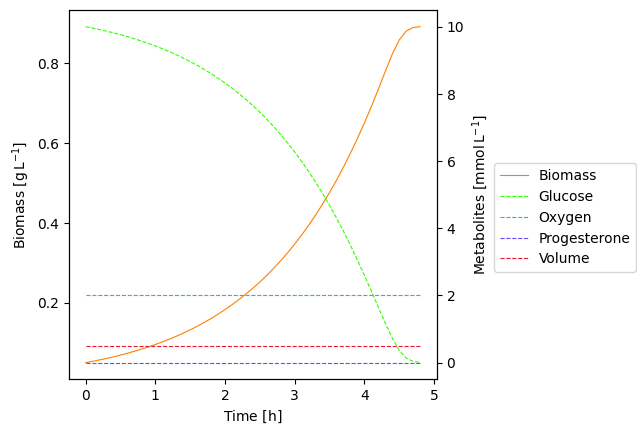

In [16]:
plot_concentrations(concentrations)

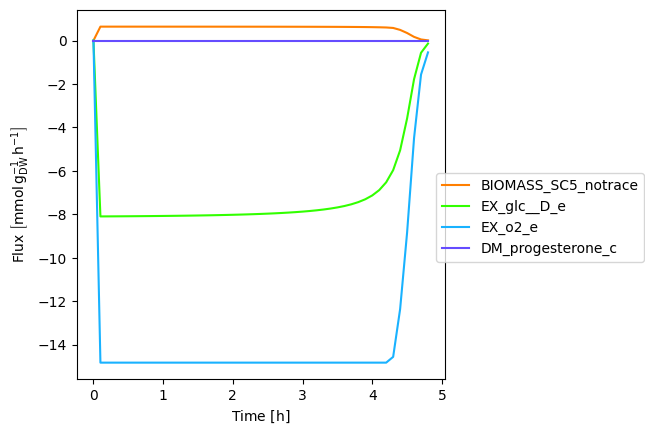

In [17]:
plot_trajectories(trajectories)